In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

# metrics
import shap 
from shap import Explainer, Explanation
shap.initjs()
import eli5
from eli5.sklearn import PermutationImportance  

# save the models
import joblib

# functions that allows our personalize functions
from helpers.helper_functions import fail_predictions_df, split_dataset, preprocess_pipeline, revert_preprocess_pipeline

# ignoring some warning for a better readability
import warnings
warnings.filterwarnings("ignore", message="Ignoring `palette` because no `hue` variable has been assigned.")
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.")

ImportError: cannot import name 'revert_preprocess_pipeline' from 'helpers.helper_functions' (D:\Data_science_code\Turing_College\00_Homework\10_GBT_&_FeatureEngineering\hjuare-DS.v2.5.3.2.5\helpers\helper_functions.py)

In [3]:
# This variable helps to re run the code if TRUE else it not will be runing the code 
run_extra_code = False

In [4]:
custom_colors = ['#36CE8A', "#7436F5", "#3736F4", "#36AEF5", "#B336F5", "#f8165e", "#36709A",  "#3672F5", "#7ACE5D"]
color_palette_custom  = sns.set_palette(custom_colors)
theme_color = sns.color_palette(color_palette_custom, 9)

theme_color

[(0.21176470588235294, 0.807843137254902, 0.5411764705882353),
 (0.4549019607843137, 0.21176470588235294, 0.9607843137254902),
 (0.21568627450980393, 0.21176470588235294, 0.9568627450980393),
 (0.21176470588235294, 0.6823529411764706, 0.9607843137254902),
 (0.7019607843137254, 0.21176470588235294, 0.9607843137254902),
 (0.9725490196078431, 0.08627450980392157, 0.3686274509803922),
 (0.21176470588235294, 0.4392156862745098, 0.6039215686274509),
 (0.21176470588235294, 0.4470588235294118, 0.9607843137254902),
 (0.47843137254901963, 0.807843137254902, 0.36470588235294116)]

In [5]:
# Load your dataset
df = pd.read_csv('healthcare-dataset-stroke-data.csv')
# df = df[df["age"] > 35]
# split the dataset
independent_var = df.iloc[:,1:11]
dependent_var = df.iloc[:,11:]

independent_var, np_array = preprocess_pipeline(dataset=independent_var,
                                                        num_features=  ["age","avg_glucose_level","bmi"],
                                                        binary_cols= ["ever_married","hypertension","heart_disease"],
                                                        categorical_cols= ["work_type","Residence_type", "smoking_status", "gender"],
                                                        numeric_preprocess= "StandardScaler",
                                                        strategy_imputer= "most_frequent")

# split the dataset
X_train, X_validation, X_test, y_train, y_validation, y_test = split_dataset(
    dependent_variable= dependent_var,
    independent_variable= independent_var,
    split_train_validation = 0.3,
    split_validation_test = 0.5, 
    state_reproducibility = 100
)

# pass to 1D the array
y_train = y_train.values.ravel()
y_validation = y_validation.values.ravel()
y_test = y_test.values.ravel()

We will first test the Naive Bayes model to evaluate its performance.

In [6]:
# Get the best model and evaluate on the test set
GNB_001_load = joblib.load('model_saved_vr2/GNB_001.pkl')
GNB_001 = GNB_001_load.best_estimator_
best_params = GNB_001_load.best_params_
best_score = GNB_001_load.best_score_
GNB_001

GaussianNB()

In [7]:
ensemble_model_002 = joblib.load('model_saved_vr2/ensemble_model_002.pkl')
ensemble_model_002

VotingClassifier(estimators=[('GNB', GaussianNB()),
                             ('adaboost',
                              AdaBoostClassifier(learning_rate=1e-05,
                                                 n_estimators=2)),
                             ('logreg',
                              LogisticRegression(C=0.0006951927961775605,
                                                 solver='liblinear'))],
                 voting='soft')

In [8]:
print(f"accuracy, GNB_001: {GNB_001.score(X_validation,y_validation)}")
print(f"accuracy, ensemble_model_002: {ensemble_model_002.score(X_validation,y_validation)}")

accuracy, GNB_001: 0.5861618798955613
accuracy, ensemble_model_002: 0.5783289817232375


# SHAP Values

## Interpretability of GNB_001

first we will predict a value and see how it performs, 1st we will be analysing the model and see how and which features are giving more predicting power 

In [9]:
# calculate shap values for any prediction
explainer = shap.KernelExplainer(GNB_001.predict_proba, X_train)

# extract the shap values from the predicted dataset
if run_extra_code:
    shap_values = explainer.shap_values(X_validation)
    
    # save the shap values
    joblib.dump(shap_values, 'model_saved_vr2/SHAP_GNB_001.pkl')  
    
# reload the shap values from the complete dataset
shap_values = joblib.load('model_saved_vr2/SHAP_GNB_001.pkl')

Using 3577 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [10]:
# extract the predictions
wrong_prediction_positive, wrong_prediction_negative = fail_predictions_df(model=GNB_001,
                                                               x_val=X_validation,
                                                                y_val= y_validation,
                                                                extract_rows_examples= 10)
             
if run_extra_code:
    # save the positive examples
    wrong_positive_shap_values = explainer.shap_values(wrong_prediction_positive)
    joblib.dump(wrong_positive_shap_values, 'model_saved_vr2/SHAP_GNB_001_positive.pkl')
    # save the negative examples
    wrong_negative_shap_values = explainer.shap_values(wrong_prediction_negative)
    joblib.dump(wrong_negative_shap_values, 'model_saved_vr2/SHAP_GNB_001_negative.pkl')

wrong_positive_shap_values = joblib.load('model_saved_vr2/SHAP_GNB_001_positive.pkl')
wrong_negative_shap_values = joblib.load('model_saved_vr2/SHAP_GNB_001_negative.pkl')

In [11]:
# extract the stroke value from the prediction
shap_values_all = shap_values
wrong_positive_shap_values = wrong_positive_shap_values[:, :, 1]
wrong_negative_shap_values  = wrong_negative_shap_values[:, :, 1]
shap_values = shap_values[:, :, 1]
wrong_positive_shap_values.shape

(4, 20)

### Global explainability
##### Stacked force plot
To understand how our model makes predictions in general we need to aggregate the SHAP values.

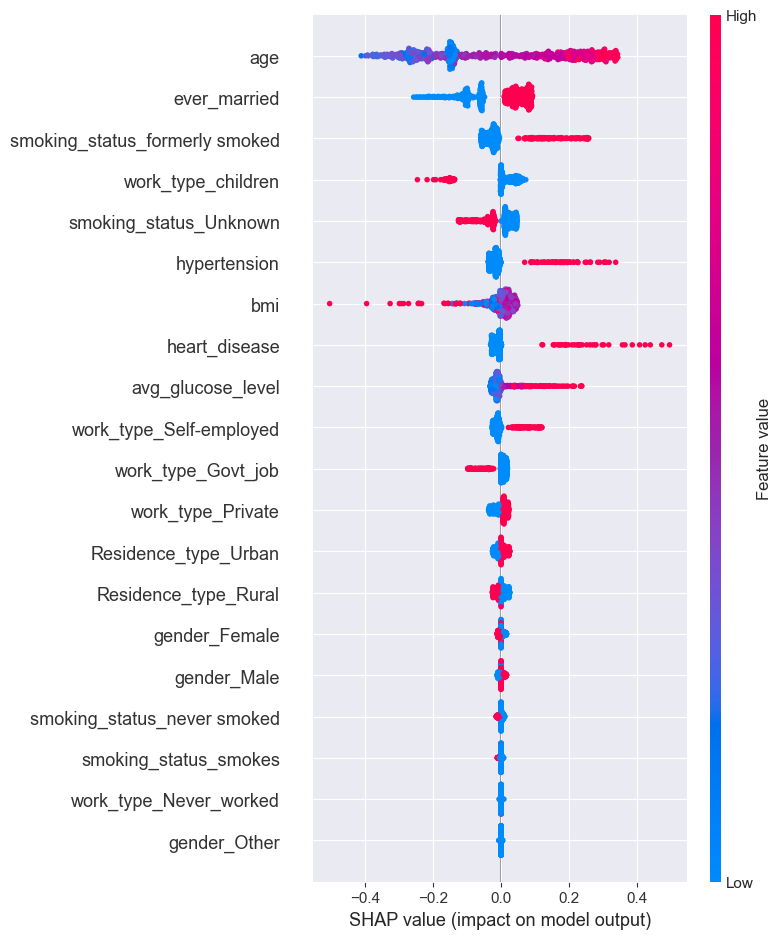

In [12]:
shap.summary_plot(shap_values, X_validation)

We observed that certain factors increase the likelihood of stroke, such as **age, smoking status (as smoker or unknown), 
hypertension, heart disease, and glucose levels**. Conversely, factors that appear to reduce the risk include **age, 
marital status, and BMI.** Age emerges as a particularly clear variable in predicting stroke probability when the
model interprets these factors.

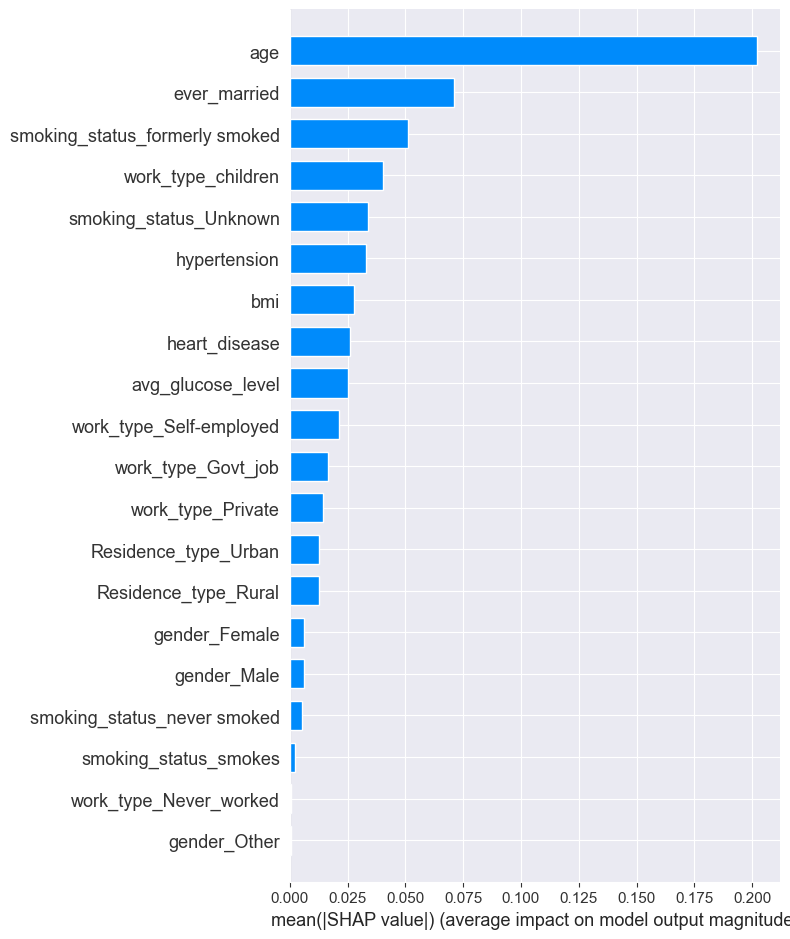

In [13]:
names_columns = X_validation.columns
shap.summary_plot(shap_values, feature_names=names_columns, max_display=len(names_columns), plot_type="bar")

We could see a lot of volatility in the age predictor value.

# Explain in group of variables
Next, we'll examine how incorrect predictions affect the outcomes.

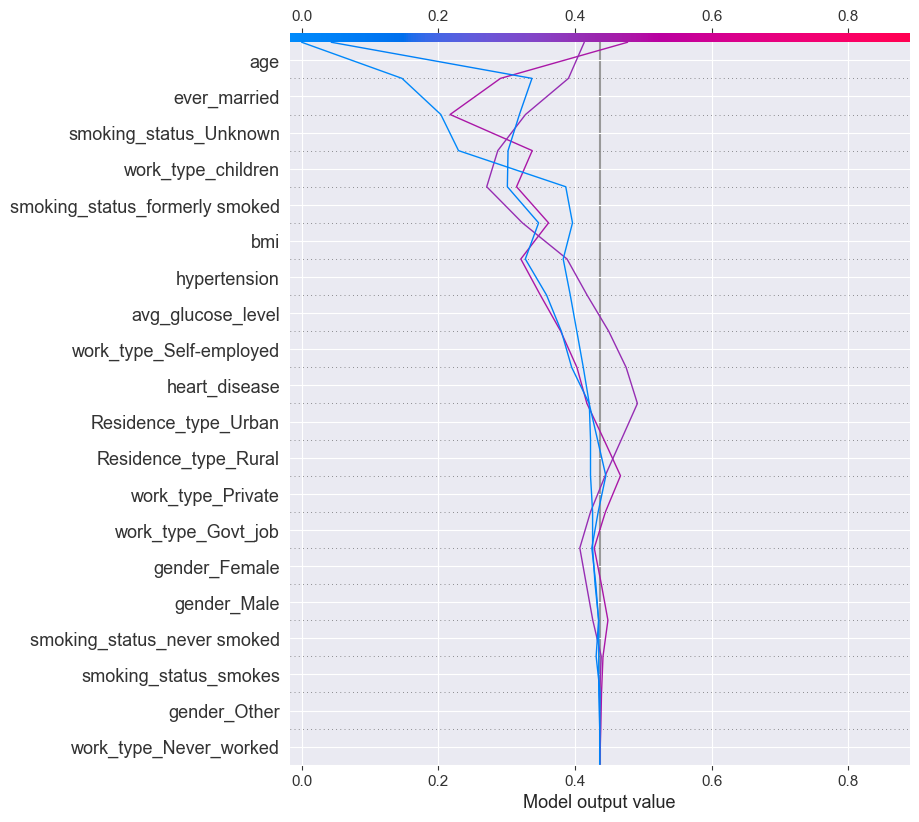

In [14]:
shap.decision_plot(explainer.expected_value[1], wrong_positive_shap_values, feature_names=names_columns.tolist())

We've observed that age is one of the reasons the model fails to predict accurately. Other factors, such as marital
status (being ever married, which correlates with age) and employment type (like having children, associated 
with younger ages), could also contribute to the model's inaccurate predictions.

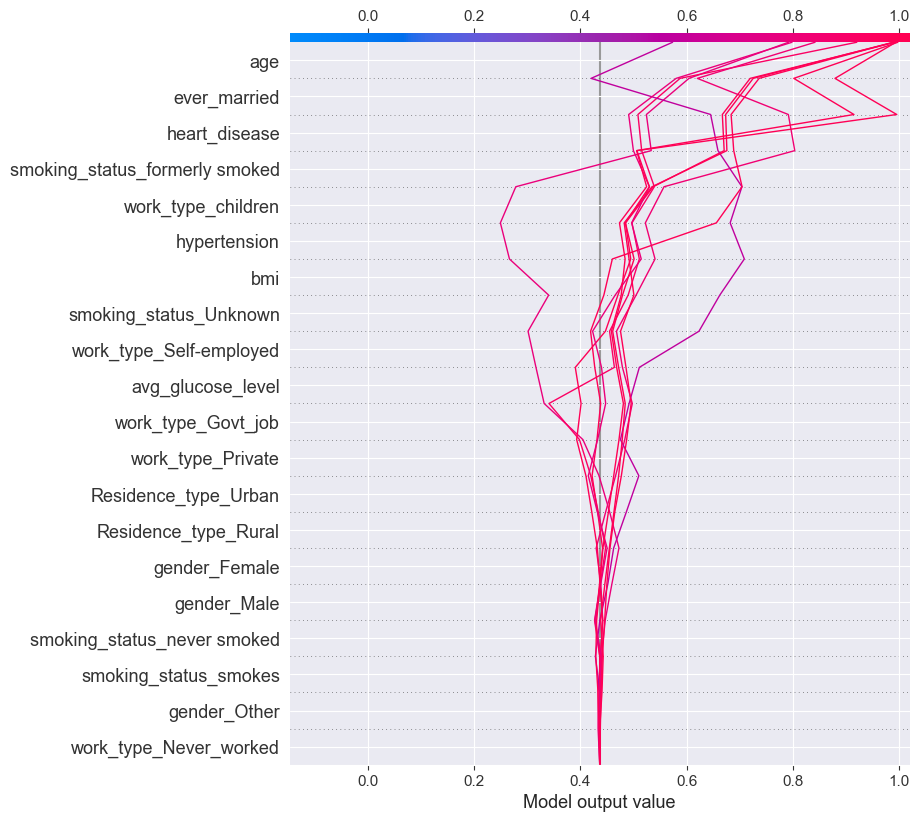

In [15]:
shap.decision_plot(explainer.expected_value[1], wrong_negative_shap_values, feature_names=names_columns.tolist())

This is where we observe numerous miss classifications with the models. However, from the chart, we notice that many 
predictions begin with miss classifications related to age, heart disease, or smoking status. These factors can
significantly impact the predictive accuracy of the model.

In [16]:
shap.force_plot(explainer.expected_value[1], shap_values, feature_names=names_columns)

In this single feature, we observe a clear evolution across certain ranges of values, highlighting distinct zones and differences. As previously noted, age exhibits the highest variability among these values.

### local explainability for individual features
we will extract 2 values of each of the predictions to understand how they predict each value

In [17]:
print(df.iloc[8:9])
print("--------------------------------------------------------------------------------")
print(df.iloc[213:214])

wrong_prediction_positive

      id  gender   age  hypertension  heart_disease ever_married work_type  \
8  27419  Female  59.0             0              0          Yes   Private   

  Residence_type  avg_glucose_level  bmi smoking_status  stroke  
8          Rural              76.15  NaN        Unknown       1  
--------------------------------------------------------------------------------
        id  gender   age  hypertension  heart_disease ever_married work_type  \
213  66866  Female  48.0             0              0          Yes   Private   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
213          Urban              74.11  20.5   never smoked       1  


,age,avg_glucose_level,bmi,ever_married,hypertension,heart_disease,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
8,0.697615,-0.662506,-0.024117,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
213,0.211114,-0.707559,-1.089418,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
245,-1.292616,-1.064899,0.261696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
182,-0.496524,-0.662947,0.131781,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [18]:
shap.force_plot(explainer.expected_value[1], wrong_positive_shap_values[0], feature_names=names_columns)

A significant portion of the predictions rely heavily on age, but this does not consistently improve accuracy. 
Conversely, smoking status tends to reduce the risk. However, the presence of NaN values in the BMI actual data 
may impact our predictions.

In [19]:
shap.force_plot(explainer.expected_value[1], wrong_positive_shap_values[1], feature_names=names_columns)

It appears that we do not observe any predicted values that increase the probability of stroke. We are particularly 
 lacking age in this context. Additionally, it seems that the predicted values for smoking are consistently absent, 
which could be influencing the outcomes.

In [20]:
print(df.iloc[388:389])
print("--------------------------------------------------------------------------------")
print(df.iloc[1398:1399])

wrong_prediction_negative.head(2)

        id gender   age  hypertension  heart_disease ever_married work_type  \
388  10504   Male  55.0             0              0          Yes  Govt_job   

    Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
388          Rural               97.4  44.6  formerly smoked       0  
--------------------------------------------------------------------------------
         id gender   age  hypertension  heart_disease ever_married work_type  \
1398  33983   Male  75.0             0              0          Yes  Govt_job   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  
1398          Rural             206.33  26.8   never smoked       0  


,age,avg_glucose_level,bmi,ever_married,hypertension,heart_disease,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
388,0.520706,-0.193194,2.041527,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1398,1.405253,2.212550,-0.270955,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [21]:
shap.force_plot(explainer.expected_value[1], wrong_negative_shap_values[0], feature_names=names_columns)

We observed an increased risk of stroke associated with being 55 years old and a former smoker. Additionally,
marital status, specifically being married, appeared to influence the model's decision in the background.

In [22]:
shap.force_plot(explainer.expected_value[1], wrong_negative_shap_values[1], feature_names=names_columns)

## Interpretability of ensemble_model_002
In this case we will be just adding 70 examples, to see how the model performs in the overall

In [23]:
# calculate shap values for any prediction
explainer = shap.KernelExplainer(ensemble_model_002.predict_proba, X_train)
X_validation_sample = X_validation[0:70] # sample from the validation set

# extract the shap values from the predicted dataset
if run_extra_code:
    shap_values = explainer.shap_values(X_validation_sample)
    
    # save the shap values
    joblib.dump(shap_values, 'model_saved_vr2/SHAP_ensemble_model_002.pkl')  
    
# reload the shap values from the complete dataset
shap_values = joblib.load('model_saved_vr2/SHAP_ensemble_model_002.pkl')

C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but AdaBoostClassifier was fitted with feature names
  warnings.warn(
C:\Users\hanns\anaconda3\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
Using 3577 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


In [24]:
# extract the predictions
wrong_prediction_positive, wrong_prediction_negative = fail_predictions_df(model=ensemble_model_002,
                                                               x_val=X_validation,
                                                                y_val= y_validation,
                                                                extract_rows_examples= 10)
    
if run_extra_code:
    # save the positive examples
    wrong_positive_shap_values = explainer.shap_values(wrong_prediction_positive)
    joblib.dump(wrong_positive_shap_values, 'model_saved_vr2/SHAP_ensemble_model_002_positive.pkl')
    # save the negative examples
    wrong_negative_shap_values = explainer.shap_values(wrong_prediction_negative)
    joblib.dump(wrong_negative_shap_values, 'model_saved_vr2/SHAP_ensemble_model_002_negative.pkl')

wrong_positive_shap_values = joblib.load('model_saved_vr2/SHAP_ensemble_model_002_positive.pkl')
wrong_negative_shap_values = joblib.load('model_saved_vr2/SHAP_ensemble_model_002_negative.pkl')

In [25]:
# extract the stroke value from the prediction
shap_values_all = shap_values
wrong_positive_shap_values = wrong_positive_shap_values[:, :, 1]
wrong_negative_shap_values  = wrong_negative_shap_values[:, :, 1]
shap_values = shap_values[:, :, 1]
wrong_positive_shap_values.shape

(3, 20)

### Global explainability
##### Stacked force plot
To understand how our model makes predictions in general we need to aggregate the SHAP values.

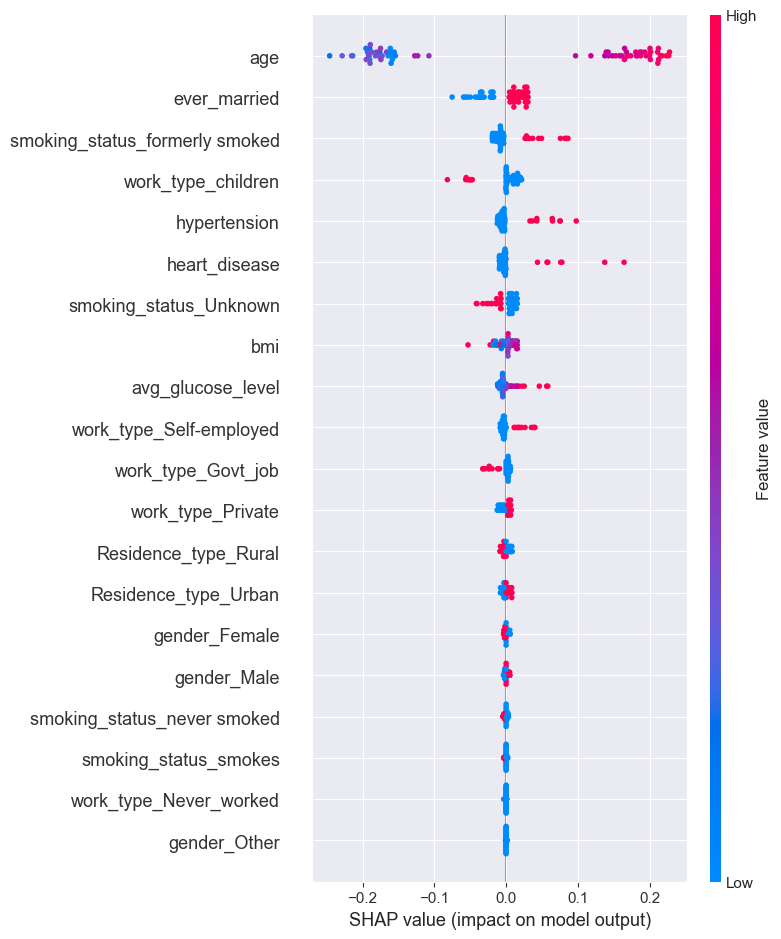

In [26]:
shap.summary_plot(shap_values, X_validation_sample)

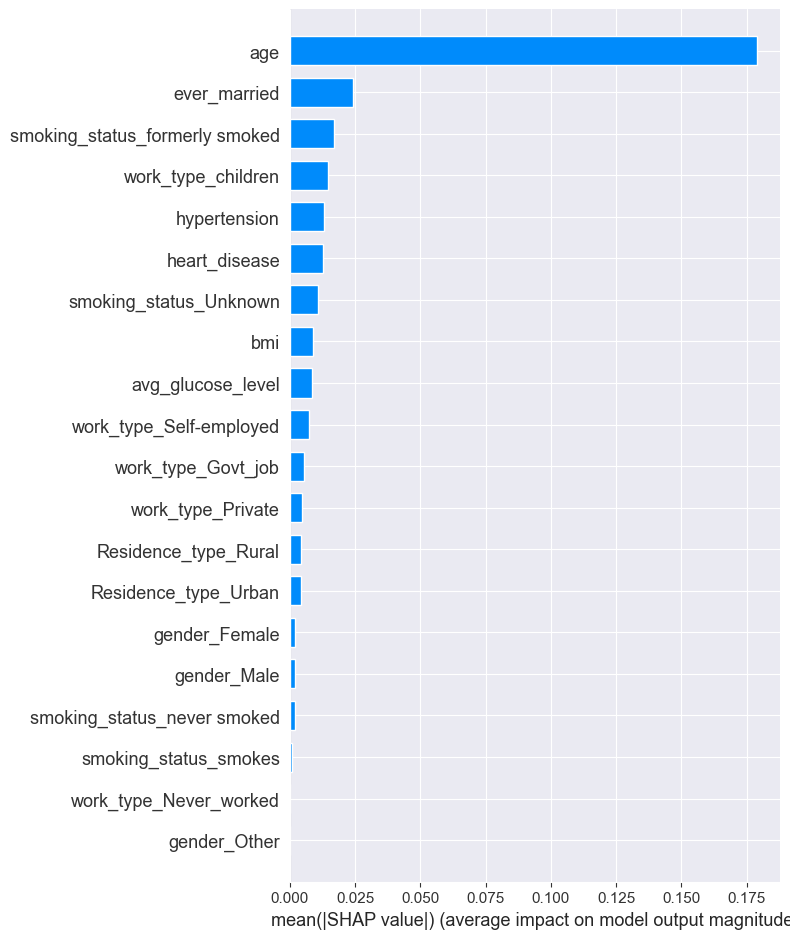

In [27]:
names_columns = X_validation_sample.columns
shap.summary_plot(shap_values, feature_names=names_columns, max_display=len(names_columns), plot_type="bar")

# Explain in group of variables
Next, we'll examine how incorrect predictions affect the outcomes.

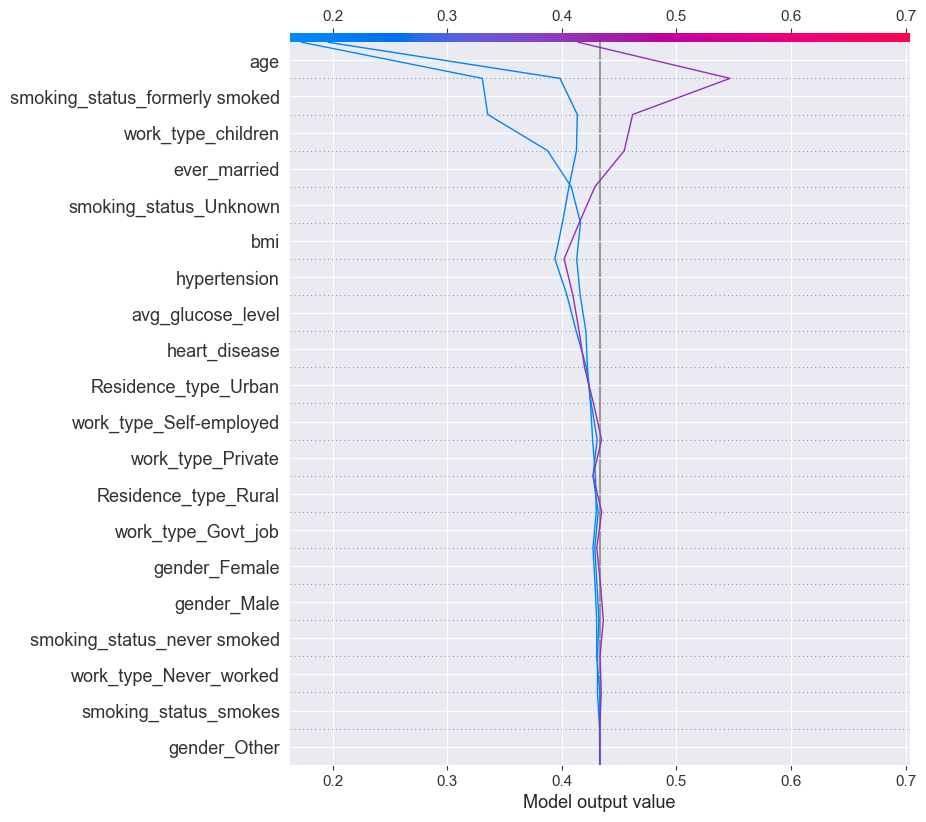

In [37]:
shap.decision_plot(explainer.expected_value[1], wrong_positive_shap_values, feature_names=names_columns.tolist())

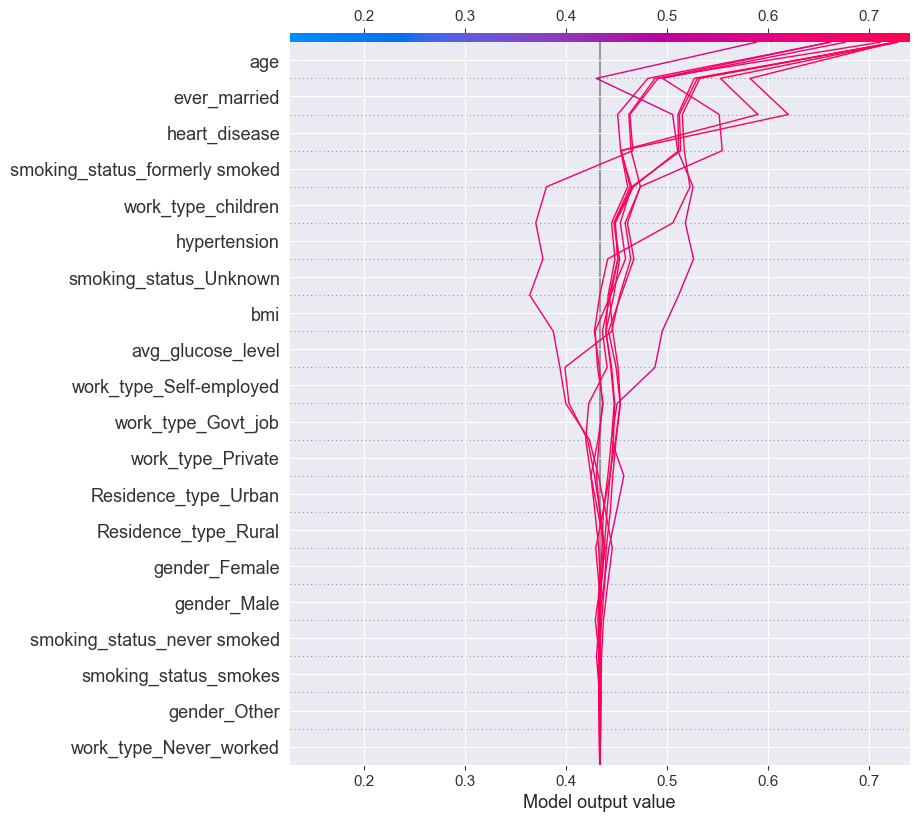

In [38]:
shap.decision_plot(explainer.expected_value[1], wrong_negative_shap_values, feature_names=names_columns.tolist())

In [30]:
shap.force_plot(explainer.expected_value[1], shap_values, feature_names=names_columns)

### local explainability for individual features
we will extract 2 values of each of the predictions to understand how they predict each value

In [41]:
print(df.iloc[246:247])
print("--------------------------------------------------------------------------------")
print(df.iloc[182:183])

wrong_prediction_positive.head(2)

        id  gender   age  hypertension  heart_disease ever_married  \
246  27153  Female  75.0             0              0          Yes   

         work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
246  Self-employed          Rural               78.8  29.3  formerly smoked   

     stroke  
246       1  
--------------------------------------------------------------------------------
        id  gender   age  hypertension  heart_disease ever_married work_type  \
182  39912  Female  32.0             0              0          Yes   Private   

    Residence_type  avg_glucose_level   bmi smoking_status  stroke  
182          Rural              76.13  29.9         smokes       1  


,age,avg_glucose_level,bmi,ever_married,hypertension,heart_disease,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
245,-1.292616,-1.064899,0.261696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
182,-0.496524,-0.662947,0.131781,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


In [44]:
shap.force_plot(explainer.expected_value[1], wrong_positive_shap_values[0], feature_names=names_columns)

In [33]:
shap.force_plot(explainer.expected_value[1], wrong_positive_shap_values[1], feature_names=names_columns)

In [42]:
print(df.iloc[388:389])
print("--------------------------------------------------------------------------------")
print(df.iloc[1398:1399])

wrong_prediction_negative.head(2)

        id gender   age  hypertension  heart_disease ever_married work_type  \
388  10504   Male  55.0             0              0          Yes  Govt_job   

    Residence_type  avg_glucose_level   bmi   smoking_status  stroke  
388          Rural               97.4  44.6  formerly smoked       0  
--------------------------------------------------------------------------------
         id gender   age  hypertension  heart_disease ever_married work_type  \
1398  33983   Male  75.0             0              0          Yes  Govt_job   

     Residence_type  avg_glucose_level   bmi smoking_status  stroke  
1398          Rural             206.33  26.8   never smoked       0  


,age,avg_glucose_level,bmi,ever_married,hypertension,heart_disease,work_type_Govt_job,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes,gender_Female,gender_Male,gender_Other
388,0.520706,-0.193194,2.041527,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1398,1.405253,2.212550,-0.270955,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


In [35]:
shap.force_plot(explainer.expected_value[1], wrong_negative_shap_values[0], feature_names=names_columns)

In [36]:
shap.force_plot(explainer.expected_value[1], wrong_negative_shap_values[1], feature_names=names_columns)

# Conclusions
- We observed that **Age** is a significant factor in the predictive model. For future steps, we should consider reducing the impact of this variable to potentially improve performance.
- Other features, such as **gender** and **residency type**, do not contribute much predictive power to the final results.
- Features like **hypertension** and **heart disease** could enhance predictability if we focus on their individual impact.